## Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import keras
from keras.models import Sequential
from keras.initializers import Constant
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import BatchNormalization
from keras.callbacks import ReduceLROnPlateau,CSVLogger
from tqdm.notebook import tqdm
import tensorflow as tf
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout, Activation,Flatten,Embedding,Conv1D, GlobalMaxPooling1D 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix,classification_report
import shutil

In [ ]:
df = pd.read_csv("/content/Final_hate.csv")
df

,Unnamed: 0,Text,label
0,0,RT @MailOnline: The Nazi death gas so horrific...,0
1,1,Carlos Correa had gyalchester as his walkup mu...,0
2,2,"""THE FORCE AWAKENS: A Bad Lip Reading"" (Featur...",0
3,3,RT @HeeeyMonica: Papaya has to be the worst fr...,0
4,4,@Pineaqples @DenialEsports btw I watched where...,0
...,...,...,...
103216,103216,you's a muthaf***in lie &#8220;@LifeAsKing: @2...,0
103217,103217,"you've gone and broke the wrong heart baby, an...",0
103218,103218,young buck wanna eat!!.. dat nigguh like I ain...,0
103219,103219,youu got wild bitches tellin you lies,0


In [ ]:
c = df.columns
c

Index(['Unnamed: 0', 'Text', 'label'], dtype='object')

In [ ]:
hate, non_hate = np.bincount(df['label'])
total = hate + non_hate
print('Examples:\n    Total: {}\n    hate: {} ({:.2f}% of total)\n'.format(
    total, hate, 100 * hate / total))
print('Examples:\n    Total: {}\n    non_hate: {} ({:.2f}% of total)\n'.format(
    total, non_hate, 100 * non_hate / total))

Examples:
    Total: 103221
    hate: 90823 (87.99% of total)

Examples:
    Total: 103221
    non_hate: 12398 (12.01% of total)



In [ ]:
df = df.fillna('')

In [ ]:
x= df['Text']
y=df['label']

In [ ]:
texts = x
target = y

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
#Downloading the Glove embedding file
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2022-06-09 02:38:05--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-06-09 02:38:06--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-06-09 02:38:06--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:
#unzipping
!unzip glove*.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [ ]:
#Get the exact path of where the embedding vectors are extracted using
!ls
!pwd

BERTContextual_30percHSnew.csv	glove.6B.200d.txt  glove.6B.zip
Final_hate.csv			glove.6B.300d.txt  sample_data
glove.6B.100d.txt		glove.6B.50d.txt
/content


In [ ]:
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(texts)
#defining vocabulary length
vocab_length = len(word_tokenizer.word_index) + 1

def embed(text_data): 
    return word_tokenizer.texts_to_sequences(text_data)

longest_train = max(texts, key=lambda sentence: len(word_tokenize(sentence)))
length_long_sentence = len(word_tokenize(longest_train))

#padding_data
train_padded_sentences = pad_sequences(
    embed(texts), 
    length_long_sentence, 
    padding='post'
)

embeddings_dictionary = dict()
embedding_dim = 100

# Loading GloVe-100D embedding_file
with open('/content/glove.6B.100d.txt') as fp:
    for line in fp.readlines():
        records = line.split()
        word = records[0]
        vector_dimensions = np.asarray(records[1:], dtype='float32')
        embeddings_dictionary[word] = vector_dimensions

# Loading embedding_vectors of words which comes in Glove files other will be equated to 0
#defining embedding matrix shape
embedding_matrix = np.zeros((vocab_length, embedding_dim))
#creating embedding matrix
for word, index in word_tokenizer.word_index.items(): 
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

## Train Test Split

In [ ]:
#set aside 20% of train and test data for evaluation
X_train, X_val, y_train, y_val = train_test_split(train_padded_sentences, target, test_size=0.2, shuffle = True, random_state = 8)


print("X_train shape: {}".format(X_train.shape))
print("X_val shape: {}".format(X_val.shape))
print("y_train shape: {}".format(y_train.shape))
print("y_val shape: {}".format(y_val.shape))


print("========================")

# Use the same function above for the validation set
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.25, random_state= 8) # 0.25 x 0.8 = 0.2


print("X_train shape: {}".format(X_train.shape))
print("y_train shape: {}".format(y_train.shape))
print("X_test shape: {}".format(X_test.shape))
print("y_test shape: {}".format(y_test.shape))




X_train shape: (82576, 1209)
X_val shape: (20645, 1209)
y_train shape: (82576,)
y_val shape: (20645,)
X_train shape: (61932, 1209)
y_train shape: (61932,)
X_test shape: (20644, 1209)
y_test shape: (20644,)


In [ ]:
reduce_lr = ReduceLROnPlateau(
    monitor = 'val_loss', 
    factor = 0.2, 
    verbose = 1, 
    patience = 5,                        
    min_lr = 0.001
)
epoch_count=20
batch_size= 128

In [ ]:
#defining_class_weight for each class
weight_class1 = (1 / hate)*(total)/2.0 
weight_class2 = (1 / non_hate)*(total)/2.0
class_weight = {1: weight_class1, 0: weight_class2}

In [ ]:
class_weight

{0: 4.162808517502823, 1: 0.5682536361934752}

In [ ]:
pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 28.9 MB/s 


## MODEL

In [ ]:
import tensorflow_addons as tfa

In [ ]:
import keras.backend as K
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [ ]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),get_f1
]

In [ ]:
def CNN():
    model = Sequential()
    #adding embedding layer
    model.add(Embedding(
        input_dim=embedding_matrix.shape[0], 
        output_dim=embedding_matrix.shape[1], 
        weights = [embedding_matrix], 
        input_length=length_long_sentence))
    # 2 CNN layer
    model.add(Conv1D(32,2,padding='valid', activation='relu')) #cnn_layer_1
    model.add(Conv1D(64,2,padding='valid',activation='relu')) #cnn_layer_2
    model.add(GlobalMaxPooling1D()) #globalmaxpooling_layer
    model.add(Dense(256, activation='relu')) #dense_layer
    model.add(Dropout(0.1)) #dropout_layer
    model.add(Dense(1, activation = 'softmax')) #classification layer
    #model.compile(loss = tf.keras.losses.binary_crossentropy, optimizer = 'adam', metrics = METRICS)
    model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)
    return model
    

In [ ]:
#builiding CNN model
model2=CNN()
 
#running mode
history2 = model2.fit(
    X_train, 
    y_train, 
    epochs = epoch_count,
    batch_size = batch_size,
    validation_data = (X_val, y_val),
    verbose = 1,
    callbacks = [reduce_lr],
    class_weight = class_weight
)

Epoch 1/20
484/484 [==============================] - 276s 568ms/step - loss: 0.2899 - accuracy: 0.1193 - precision: 0.1193 - recall: 1.0000 - get_f1: 0.2121 - val_loss: 0.2978 - val_accuracy: 0.1228 - val_precision: 0.1228 - val_recall: 1.0000 - val_get_f1: 0.2173 - lr: 0.0010
Epoch 2/20
484/484 [==============================] - 272s 562ms/step - loss: 0.1985 - accuracy: 0.1193 - precision: 0.1193 - recall: 1.0000 - get_f1: 0.2121 - val_loss: 0.2671 - val_accuracy: 0.1228 - val_precision: 0.1228 - val_recall: 1.0000 - val_get_f1: 0.2173 - lr: 0.0010
Epoch 3/20
484/484 [==============================] - 276s 571ms/step - loss: 0.1359 - accuracy: 0.1193 - precision: 0.1193 - recall: 1.0000 - get_f1: 0.2122 - val_loss: 0.2680 - val_accuracy: 0.1228 - val_precision: 0.1228 - val_recall: 1.0000 - val_get_f1: 0.2173 - lr: 0.0010
Epoch 4/20
484/484 [==============================] - 275s 569ms/step - loss: 0.0779 - accuracy: 0.1193 - precision: 0.1193 - recall: 1.0000 - get_f1: 0.2120 - val

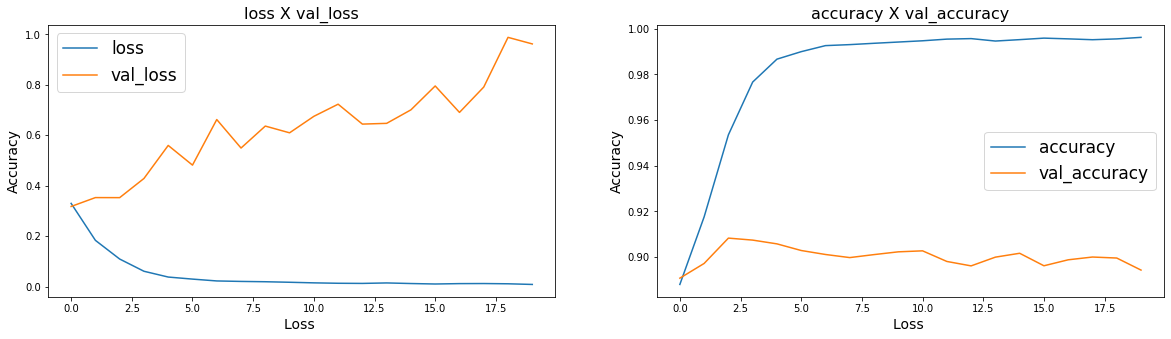

In [ ]:
def plot_learning_curves(history2, arr):
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    for idx in range(2):
        ax[idx].plot(history2.history[arr[idx][0]])
        ax[idx].plot(history2.history[arr[idx][1]])
        ax[idx].legend([arr[idx][0], arr[idx][1]],fontsize=17)
        ax[idx].set_xlabel('Loss ',fontsize=14)
        ax[idx].set_ylabel('Accuracy',fontsize=14)
        ax[idx].set_title(arr[idx][0] + ' X ' + arr[idx][1],fontsize=16)
plot_learning_curves(history2, [['loss', 'val_loss'],['accuracy', 'val_accuracy']])

In [ ]:

#predicting
pred2= np.argmax(model2.predict(X_test), axis=-1)
#printing reports
print(classification_report(y_test,pred2 ))
print(confusion_matrix(y_test, pred2))

              precision    recall  f1-score   support

           0       0.93      0.96      0.94     18171
           1       0.61      0.45      0.52      2473

    accuracy                           0.90     20644
   macro avg       0.77      0.71      0.73     20644
weighted avg       0.89      0.90      0.89     20644

[[17472   699]
 [ 1363  1110]]
